In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib import rc
rc('font',**{'family':'sans-serif', 'sans-serif':['Source Sans Pro'], 'size':10})

In [46]:
deb = ['0.05', '0.1', '0.15', '0.2', '0.25']
att = ['1.6', '1.8', '2.0', '2.2', '2.4', '2.6']
pss = ['10']
repeats = 30
basedir = '/Volumes/manoharan_lab/apaine/Code/disassembly/packaging_sites/1_PS_off/analysis'

In [ ]:
# Read raw analysis from files

cluster_data = {}
bond_data = {}
adsorbed_data = {}

for d in deb:
    cluster_data[d] = {}
    bond_data[d] = {}
    adsorbed_data[d] = {}
    for a in att:
        cluster_data[d][a] = []
        bond_data[d][a] = []
        adsorbed_data[d][a] = []
        for i in range(repeats):
            cluster_data[d][a].append(np.loadtxt(basedir + '/raw/cluster_DEB-%s_ATT-%s_PSS-%s_%s.txt' % (d, a, pss[0],str(i))))
            bond_data[d][a].append(np.loadtxt(basedir + '/raw/bonds_DEB-%s_ATT-%s_PSS-%s_%s.txt' % (d, a, pss[0],str(i))))
            adsorbed_data[d][a].append(np.loadtxt(basedir + '/raw/adsorbed_DEB-%s_ATT-%s_PSS-%s_%s.txt' % (d, a, pss[0],str(i))))

x_scale = np.loadtxt(basedir + '/xscale/xscale.txt')

In [47]:
pairs_data = {}

for d in deb:
    pairs_data[d] = {}
    for a in att:
        pairs_data[d][a] = []
        for i in range(repeats):
            single_trajectory_pairs = []
            with open(basedir + '/raw/pairs_DEB-%s_ATT-%s_PSS-%s_%s.txt' % (d, a, pss[0], str(i)), 'r') as f:
                for line in f.readlines():
                    pairs = [pair.split('|') for pair in line.strip().split(' ')]
                    single_trajectory_pairs.append(pairs)
            pairs_data[d][a].append(single_trajectory_pairs)

In [48]:
# Which capsomer initiates disassembly? First to reach 1 bond.
disassembly_initiators = {}

for d in deb:
    disassembly_initiators[d] = {}
    for a in att:
        disassembly_initiators[d][a] = []
        for traj in pairs_data[d][a]:
            for frame_pairs in traj:
                bodies, counts = np.unique(frame_pairs, return_counts=True)
                try:
                    index = list(counts).index(1)
                    disassembly_initiators[d][a].append(bodies[index])
                    break
                except ValueError:
                    continue

In [90]:
np.unique(disassembly_initiators, return_counts=True)

(array(['1039', '1097', '1155', '1213', '575', '633', '691', '749', '807',
        '923', '981'], dtype='<U4'),
 array([5, 3, 2, 1, 2, 3, 4, 1, 2, 3, 4]))

In [91]:
all_bodies = np.sort(list(map(int, np.unique(pairs_data[0][0]))))

In [92]:
body_count = []
for body in all_bodies:
    body_count.append(disassembly_initiators.count(str(body)))

In [93]:
counts_data = pd.DataFrame({
    'body': all_bodies,
    'count': body_count
})

In [94]:
counts_data.to_csv(basedir + '/counts.csv')

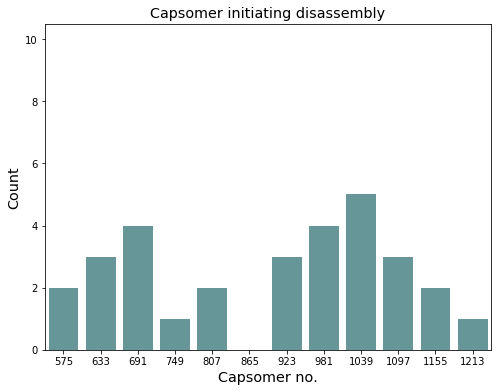

In [95]:
plt.figure(figsize=(8, 6))
sns.countplot(list(map(int, disassembly_initiators)), order=all_bodies, color='cadetblue')
plt.xlabel('Capsomer no.', size='x-large')
plt.ylabel('Count', size='x-large')
plt.title('Capsomer initiating disassembly', size='x-large')
plt.ylim(0, 10.5)
plt.savefig(basedir + '/plots/disassembly-initiation.pdf')

In [3]:
from scipy.stats import entropy
uniform = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [12]:
isotropic = False

if isotropic:
    basedir1 = './packaging_sites/1_PS_off/analysis'
    basedir2 = './polymer_path_disassembly_1/analysis'
else:
    basedir1 = './packaging_sites/0_PS_off/analysis'
    basedir2 = './polymer_path_disassembly_0/analysis'
data1 = pd.read_csv(basedir1 + '/counts.csv')
data2 = pd.read_csv(basedir2 + '/counts.csv')
bodies = np.array(data1['body'])
counts = np.array(data1['count'] + data2['count'])

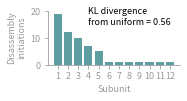

In [13]:
# Plot disassembly initiators

plt.figure(figsize=(2.7, 1.5))
ax = plt.gca()
gray_ax = '#999999'
ax.tick_params(color=gray_ax, labelcolor=gray_ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(gray_ax)
ax.spines['left'].set_color(gray_ax)
    
#sorted_counts = np.sort(counts)[::-1]

count_order = np.argsort(counts)
sorted_counts = counts[count_order[::-1]]
sorted_bodies = bodies[count_order[::-1]]

for i in range(len(bodies)):
    plt.bar(i+1, sorted_counts[i], width=0.8, align='center', label='observed', color='cadetblue')
plt.xticks(range(1, 13))
plt.xlabel('Subunit', color=gray_ax)
plt.ylim(0, 20)
plt.ylabel('Disassembly\ninitiations', color=gray_ax)
plt.text(4, 15, 'KL divergence\nfrom uniform = %s' % (str(np.round(entropy(counts, qk=uniform), decimals=2))))
plt.tight_layout()
if isotropic:
    plt.savefig('../paper_plots/anisotropy/initiators_isotropic.pdf')
else:
    plt.savefig('../paper_plots/anisotropy/initiators_anisotropic.pdf')
plt.show()

In [14]:
# Plot initial reinforcements for each subunit in the same order as the initiator plot
basedir = '/Volumes/manoharan_lab/apaine/Code/disassembly/packaging_sites/'

if isotropic:
    batch = '1_PS_off'
else:
    batch = '0_PS_off'

def read_pairs(f):
    text_pairs = np.loadtxt(f, dtype='str', delimiter='\n')
    list_pairs = [[pair.split('|') for pair in line.strip().split(' ')] for line in text_pairs]
    return list_pairs

def flatten(l):
    try:
        return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]
    except IndexError:
        return []

init_pairs_strong = read_pairs(basedir + batch + '/analysis/raw/polymerconnections_DEB-0.2_ATT-2.0_PSS-10_0.txt')[0]
init_pairs_weak = read_pairs(basedir + batch + '/analysis/raw/polymerconnections2_DEB-0.2_ATT-2.0_PSS-10_0.txt')[0]
strong_subunits, strong_reinforcement_counts = np.unique(flatten(init_pairs_strong), return_counts=True)
strong_subunits = np.array(list(map(int, map(float, strong_subunits))))
weak_subunits, weak_reinforcement_counts = np.unique(flatten(init_pairs_weak), return_counts=True)
weak_subunits = np.array(list(map(int, map(float, weak_subunits))))

In [15]:
strong = []
weak = []
non = []

for body in sorted_bodies:
    strong_count = strong_reinforcement_counts[np.where(strong_subunits == body)]
    weak_count = weak_reinforcement_counts[np.where(weak_subunits == body)] - strong_count
    non_count = 10 - strong_count - weak_count
    strong.append(int(strong_count/2))
    weak.append(int(weak_count/2))
    non.append(int(non_count/2))

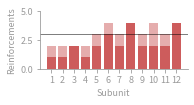

In [16]:
# Plot initial reinforcement state

plt.figure(figsize=(2.7, 1.5))
ax = plt.gca()
gray_ax = '#999999'
ax.tick_params(color=gray_ax, labelcolor=gray_ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(gray_ax)
ax.spines['left'].set_color(gray_ax)

for i in range(len(bodies)):
    plt.bar(i+1, strong[i], width=0.8, align='center', color='indianred')
for i in range(len(bodies)):
    plt.bar(i+1, weak[i], width=0.8, align='center', color='indianred', alpha=0.5, bottom=strong[i])
plt.xticks(range(1, 13))
plt.xlabel('Subunit', color=gray_ax)
plt.ylim(0, 5)
plt.ylabel('Reinforcements', color=gray_ax)
plt.tight_layout()
plt.axhline(np.mean(np.array(strong)+np.array(weak)), c='k', lw=0.5)
if isotropic:
    plt.savefig('../paper_plots/anisotropy/initial_reinforcement_isotropic.pdf')
else:
    plt.savefig('../paper_plots/anisotropy/initial_reinforcement_anisotropic.pdf')
plt.show()

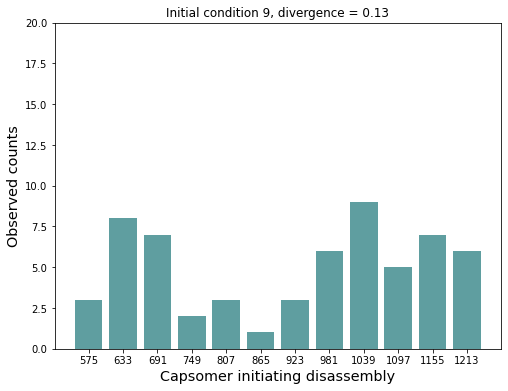

In [27]:
plt.figure(figsize=(8, 6))
for i in range(len(bodies)):
    plt.bar(i + 0.5, counts[i], width=0.8, align='center', label='observed', color='cadetblue')
plt.xticks(np.arange(0.5, len(bodies) + 0.5, 1), bodies)
plt.xlabel('Capsomer initiating disassembly', fontsize='x-large')
plt.ylim(0, 20)
plt.ylabel('Observed counts', fontsize='x-large')
plt.title('Initial condition 9, divergence = %s' % (str(np.round(entropy(counts, qk=uniform), decimals=2))))
plt.savefig(basedir1 + '/plots/initiators.pdf')
plt.savefig('/Volumes/manoharan_lab/apaine/Code/disassembly/packaging_sites/plots/initiators_9.pdf')
plt.show()

In [39]:
all_bodies = np.sort(list(map(int, np.unique(pairs_data[deb[0]][att[0]][0][0]))))

In [40]:
all_bodies

array([ 575,  633,  691,  749,  807,  865,  923,  981, 1039, 1097, 1155,
       1213])

In [49]:
divergences = np.zeros((len(deb), len(att)))
annotations = np.empty((len(deb), len(att)), dtype=object)

for d in range(len(deb)):
    for a in range(len(att)):
        body_count = []
        for body in all_bodies:
            body_count.append(disassembly_initiators[deb[d]][att[a]].count(str(body)))
        divergences[d][a] = entropy(body_count, qk=uniform)
        annotations[d][a] = "{:.2f}".format(entropy(body_count, qk=uniform))

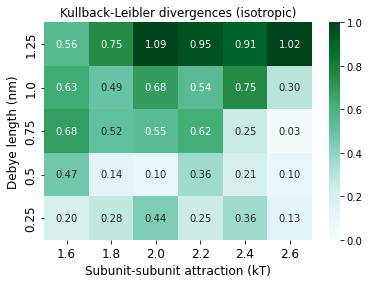

In [51]:
# Heatmaps of individual pathways
ax = plt.figure(figsize=(6, 4)).gca()
sns.heatmap(divergences[::-1],
            cmap='BuGn', vmin=0, vmax=1, annot=annotations[::-1], fmt = '')
plt.xticks(ticks=np.arange(0.5, len(att)+0.5, 1), labels=att, fontsize='large')
plt.yticks(ticks=np.arange(0.5, len(deb)+0.5, 1), labels=list(map(str, 5 * np.array(list(map(float, deb)))))[::-1], fontsize='large')
plt.xlabel('Subunit-subunit attraction (kT)', fontsize='large')
plt.ylabel('Debye length (nm)', fontsize='large')
plt.title('Kullback-Leibler divergences (isotropic)')
plt.savefig(basedir + '/plots/entropy_heatmap_0.pdf')
plt.show()

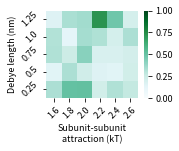

In [55]:
# Small heatmap for paper
ax = plt.figure(figsize=(2.5, 2.2)).gca()
sns.heatmap(divergences[::-1],
            cmap='BuGn', vmin=0, vmax=1)
plt.xticks(ticks=np.arange(0.5, len(att)+0.5, 1), labels=att, rotation=45)
plt.yticks(ticks=np.arange(0.5, len(deb)+0.5, 1), labels=list(map(str, 5 * np.array(list(map(float, deb)))))[::-1], rotation=45)
plt.xlabel('Subunit-subunit\nattraction (kT)')
plt.ylabel('Debye length (nm)')
plt.tight_layout()
plt.savefig('../paper_plots/anisotropy/KL_heatmap_isotropic.pdf')
plt.show()